In [1]:
# Eran Mukamel, February 2021
# 
# Add a gene-by-cell matrix (gmat) to a .snap file. This should be equivalent to:  
#   snaptools snap-add-gmat
#
# Usage: snap2gmat <snap-file> <genes-file>
#
# Inputs:
#  snap_file = path to .snap file
#  genes_file = path to bed file of genes 
#
# Output
#  Saves a file <snap-file>.gmat.npz

import pandas as pd
import numpy as np
import re,os,sys
import h5py,time
from scipy.sparse import coo_matrix

import anndata as ad
from __global_variables import *
from utils_new import *

/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
# My attempt at a faster implementation of snaptools snap-add-gmat
def assign_genes(filename,
                 genes,
                 istart=None,
                 istop=None,
                 verbose=False):
    from scipy.sparse import coo_matrix
    t0=time.time()
    with h5py.File(filename,'r') as file:
        if istart is None:
            istart=0
        if istop is None:
            istop=file['FM/fragStart'].shape[0]

        # Assign every fragment to a gene. NOTE: This will assign every fragment to ONE gene, even if it overlaps multiple genes
        fragChrom = file['FM/fragChrom'][istart:istop].astype(str)
        fragStart = file['FM/fragStart'][istart:istop]
        fragEnd = fragStart + file['FM/fragLen'][istart:istop]

        # Figure out the barcode index for each fragment
        bc_pos = file['FM/barcodePos'][:]-1
        bc_pos = np.append(bc_pos,np.inf)
        fragBC = np.digitize(istart+np.arange(len(fragChrom)), bc_pos)
        nbc = file['FM/fragChrom'].shape[0]
#         # TEMPORARY: Create smaller dataset for testing    
#         nbc = min(nbc, 100000)
    if verbose:
        print('Loaded data; t=%3.3f s' % (time.time()-t0))
    
    t0=time.time()
    fragGene = np.empty(len(fragEnd))
    i,j = np.array([],dtype=int),np.array([],dtype=int)
    chroms = genes['chr'].unique()
    for chrom in chroms:
        gu = genes[genes['chr']==chrom]
        fu = fragChrom==chrom
        if fu.any():
            fstart = fragStart[fu]
            fend = fragEnd[fu]
            fgene = fragGene[fu]
            fbc = fragBC[fu]
            
            for gi in range(gu.shape[0]):
                overlap_barcodes = fbc[(fend>gu.iloc[gi]['start']) & (fstart<gu.iloc[gi]['end'])]
                if len(overlap_barcodes)>0:
                    i=np.append(i,[gu.index[gi]]*len(overlap_barcodes))
                    j=np.append(j,overlap_barcodes)
        if verbose:
            print('%s, %d genes, %d fragments, %d total overlaps, t=%3.3fs' % (chrom,gu.shape[0],fu.sum(),len(i),time.time()-t0))
    ngenes = genes.shape[0]
    gmat = coo_matrix((np.ones(len(i)), (i,j-1)), shape=(ngenes,nbc))
    return gmat

In [3]:
# gene annotation file
genes = get_gene_annotation()
print(genes.shape)

(32285, 5)


In [5]:

snap_file = "./datasets/CEMBA190214_11E.snap"

print('*** Creating gene-by-cell matrix (gmat) from snap file')
print('*** Processing %s:' % snap_file)

# TODO: Filter out cells with < 1000 reads
with h5py.File(snap_file,'r') as file:
    nbc = file['FM/fragChrom'].shape[0]
#     # TEMPORARY: Create smaller dataset for testing    
#     nbc = min(nbc, 100000)

chunksize = int(1e6)
t0=time.time()
print(t0, nbc, chunksize)
ngenes = genes.shape[0]
gmat = coo_matrix((ngenes,nbc), np.int)
for istart in np.arange(0,nbc,chunksize):
    gmat += assign_genes(snap_file,genes,istart=istart,istop=istart+chunksize)
    tcurr = time.time()-t0
    print('%d/%d: t=%3.3f s; estimated total time = %3.3f min' % (istart+chunksize,nbc,tcurr,
                                                           tcurr*nbc/(istart+chunksize)/60))
    
    

*** Creating gene-by-cell matrix (gmat) from snap file
*** Processing ./datasets/CEMBA190214_11E.snap:
1617321848.3694398 43854379 1000000
1000000/43854379: t=24.611 s; estimated total time = 17.989 min
2000000/43854379: t=51.031 s; estimated total time = 18.650 min
3000000/43854379: t=76.634 s; estimated total time = 18.671 min
4000000/43854379: t=101.888 s; estimated total time = 18.618 min
5000000/43854379: t=127.391 s; estimated total time = 18.622 min
6000000/43854379: t=154.589 s; estimated total time = 18.832 min
7000000/43854379: t=180.648 s; estimated total time = 18.862 min
8000000/43854379: t=205.113 s; estimated total time = 18.740 min
9000000/43854379: t=228.265 s; estimated total time = 18.538 min
10000000/43854379: t=251.781 s; estimated total time = 18.403 min
11000000/43854379: t=276.965 s; estimated total time = 18.403 min
12000000/43854379: t=301.451 s; estimated total time = 18.361 min
13000000/43854379: t=324.313 s; estimated total time = 18.234 min
14000000/438543

In [13]:
# Aditya: Save anndata

with h5py.File(snap_file,'r') as file:
    print(file['BD']['name'])

# TODO: Set obs to numerical index
n_genes, n_obs = gmat.shape
obs_df = pd.DataFrame(index=pd.RangeIndex(start=0, stop=n_obs))
print(gmat.T.shape, len(genes))
adata = ad.AnnData(X = gmat.T,
                   obs = obs_df,
                   var = genes,
                   )
results_file = snap_file.replace('.snap', '.h5ad')
results_file = 'test.h5ad'
adata.write_h5ad(results_file)

<HDF5 dataset "name": shape (13257,), type "|O">
(43854379, 32285) 32285


Transforming to str index.
Transforming to str index.
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/anndata/core/anndata.py:1328: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  and not is_categorical(df[key])
... storing 'chr' as categorical
... storing 'gene' as categorical
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/anndata/core/anndata.py:108: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif is_categorical(df[k]):
/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/anndata/core/anndata.py:101: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[k]) and not is_categorical(df[k]):


In [6]:
gmat

<32285x43854379 sparse matrix of type '<class 'numpy.float64'>'
	with 22419186 stored elements in Compressed Sparse Row format>

In [7]:
cell_cov

array([3547., 2711., 2928., ...,    0.,    0.,    0.])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


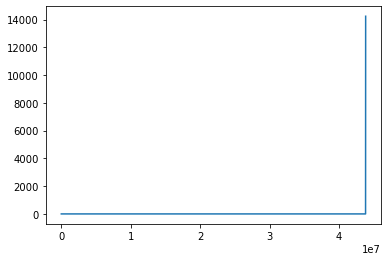

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(np.sort(cell_cov))
plt.show()

In [9]:
np.max(cell_cov)
np.min(cell_cov)

0.0

In [10]:
cell_cov > 5

array([ True,  True,  True, ..., False, False, False])

In [19]:
print(cell_cov[cell_cov > 0].shape)
print(cell_cov[cell_cov > 0].shape)
print(cell_cov[cell_cov > 100].shape)

(13257,)
(13257,)
(13186,)


In [20]:
cell_cov.shape

(43854379,)

In [16]:
# select counts > 0 is very important

cell_cov = np.ravel(gmat.sum(axis=0))

<32285x43854379 sparse matrix of type '<class 'numpy.float64'>'
	with 22419186 stored elements in Compressed Sparse Row format>

In [30]:
gmat_new = gmat.tocsc()[:,np.where(cell_cov>0)[0]]

In [31]:
gmat_new

<32285x13257 sparse matrix of type '<class 'numpy.float64'>'
	with 22419186 stored elements in Compressed Sparse Column format>

In [35]:
# TODO: Set obs to numerical index
n_genes, n_obs = gmat_new.shape
obs_df = pd.DataFrame(index=pd.RangeIndex(start=0, stop=n_obs))
adata = ad.AnnData(X = gmat_new.T,
                   obs = obs_df,
                   var = genes,
                   )
results_file = snap_file.replace('.snap', '.h5ad')
results_file = 'test.h5ad'
adata.write_h5ad(results_file)

Transforming to str index.
Transforming to str index.
... storing 'chr' as categorical
... storing 'gene' as categorical
